### Import dependencies

In [1]:
import os
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import librosa as li
import soundfile as sf
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Build and train Keras models

### A. CNN model using MFCCs as input

#### A. Read JSON data and generate train/test/validation splits using MFCC data

In [40]:
def generate_splits_mfcc(data_path, val_split=0.3, test_split=0.2):
    # Read JSON and extract X and Y values
    with open(data_path, 'r') as jf:
        data = json.load(jf)
    x = np.array(data['mfccs'])
    y = np.array(data['encoded_labels'])
    label_map = data['label_map']

    # Generate splits
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_split)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=test_split)

    # Add third dimension to MFCC arrays
    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    x_val = x_val[..., np.newaxis]

    return x_train, x_test, x_val, y_train, y_test, y_val, label_map

In [42]:
json_path = '..\\datasets\\xeno-canto_argentina\\preprocessed_data.json'

x_train, x_test, x_val, y_train, y_test, y_val, label_map = generate_splits_mfcc(json_path)

print(
    f'• Train dataset: {x_train.shape[0]} files \n• Validation dataset: {x_val.shape[0]} files \n• Test dataset: {x_test.shape[0]} files'
)

• Train dataset: 5077 files 
• Validation dataset: 1741 files 
• Test dataset: 436 files


#### Define and compile the model

In [55]:
BATCH_SIZE = 32
EPOCHS = 100

In [56]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
class_count = len(label_map)

#TODO: add and test data augmentation layers

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=input_shape),
        # Convolution layer 1
        keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
        # Convolution layer 2
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
        # Convolution layer 3
        # keras.layers.Conv2D(
        #     filters=32,
        #     kernel_size=(2, 2),
        #     activation='relu',
        #     kernel_regularizer=keras.regularizers.l2(0.001),
        # ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # Dense layer
        keras.layers.Flatten(),
        keras.layers.Dense(units=256, activation='relu'),
        keras.layers.Dropout(0.4),
        # Classification layer
        keras.layers.Dense(units=class_count, activation='softmax'),
    ]
)

model.summary()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 30, 24, 64)        640       
                                                                 
 batch_normalization_15 (Bat  (None, 30, 24, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 15, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 13, 10, 32)        18464     
                                                                 
 batch_normalization_16 (Bat  (None, 13, 10, 32)       128       
 chNormalization)                                                
                                                     

#### Train the model

In [57]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/100
159/159 [==============================] - 4s 22ms/step - loss: 3.4304 - accuracy: 0.1956 - val_loss: 2.4669 - val_accuracy: 0.4227
Epoch 2/100
159/159 [==============================] - 3s 22ms/step - loss: 2.2295 - accuracy: 0.4302 - val_loss: 1.8183 - val_accuracy: 0.5273
Epoch 3/100
159/159 [==============================] - 4s 24ms/step - loss: 1.7000 - accuracy: 0.5588 - val_loss: 1.4096 - val_accuracy: 0.6209
Epoch 4/100
159/159 [==============================] - 4s 23ms/step - loss: 1.3980 - accuracy: 0.6287 - val_loss: 1.2615 - val_accuracy: 0.6594
Epoch 5/100
159/159 [==============================] - 4s 22ms/step - loss: 1.1662 - accuracy: 0.6860 - val_loss: 1.1668 - val_accuracy: 0.6875
Epoch 6/100
159/159 [==============================] - 3s 21ms/step - loss: 1.0092 - accuracy: 0.7321 - val_loss: 1.0732 - val_accuracy: 0.7157
Epoch 7/100
159/159 [==============================] - 3s 19ms/step - loss: 0.9144 - accuracy: 0.7530 - val_loss: 0.9041 - val_accuracy:

#### Plot model accuracy and loss graphs

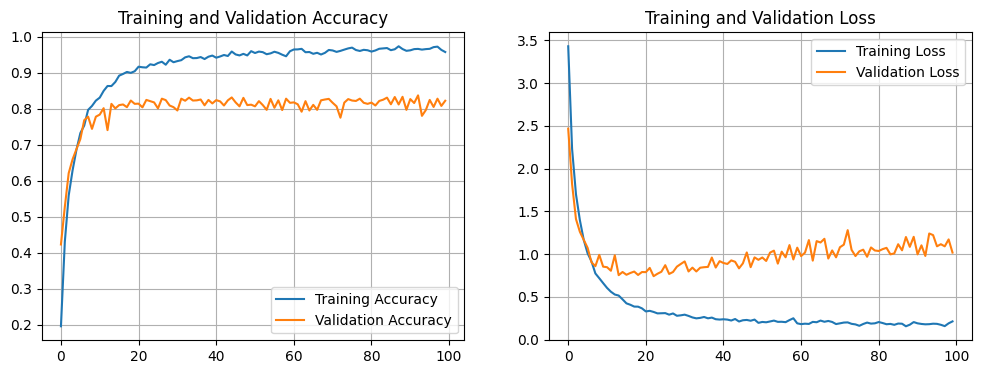

In [58]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

figure = plt.gcf()
plt.show()

### B. CNN model using Mel spectrograms as input

#### Read JSON data and generate train/test/validation splits using spectrogram data from disk

In [4]:
def generate_splits_spectrogram(data_path, val_split=0.2, test_split=0.1):
    # Read JSON and get X and Y values
    with open(data_path, 'r') as jf:
        data = json.load(jf)
    x_paths = data['spectrograms']
    y = np.array(data['encoded_labels'])
    label_map = data['label_map']

    # Load spectrograms into numpy array
    x = [np.load(path) for path in x_paths]
    x = np.array(x)

    # Generate splits
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_split)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=test_split)

    # Add third dimension to MFCC arrays
    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    x_val = x_val[..., np.newaxis]

    return x_train, x_test, x_val, y_train, y_test, y_val, label_map

In [5]:
json_path = '..\\datasets\\british-birdsong-dataset\\preprocessed_data.json'

x_train, x_test, x_val, y_train, y_test, y_val, label_map = generate_splits_spectrogram(json_path)

print(
    f'• Train dataset: {x_train.shape[0]} files \n• Validation dataset: {x_val.shape[0]} files \n• Test dataset: {x_test.shape[0]} files'
)

• Train dataset: 2049 files 
• Validation dataset: 461 files 
• Test dataset: 52 files


#### Define and compile the model

In [6]:
BATCH_SIZE = 32
EPOCHS = 60

In [7]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
class_count = len(label_map)

#TODO: add and test data augmentation layers

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=input_shape),
        # Convolution layer 1
        keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
        # Convolution layer 2
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
        # Convolution layer 3
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(2, 2),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # Dense layer
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.4),
        # Classification layer
        keras.layers.Dense(units=class_count, activation='softmax'),
    ]
)

model.summary()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 126, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 92, 126, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 61, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 61, 32)       128       
 hNormalization)                                                 
                                                        

#### Train the model

In [8]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/60
65/65 [==============================] - 17s 246ms/step - loss: 3.5716 - accuracy: 0.2704 - val_loss: 6.3148 - val_accuracy: 0.0889
Epoch 2/60
65/65 [==============================] - 16s 245ms/step - loss: 2.3723 - accuracy: 0.4695 - val_loss: 10.5310 - val_accuracy: 0.0889
Epoch 3/60
65/65 [==============================] - 17s 257ms/step - loss: 1.8890 - accuracy: 0.5666 - val_loss: 13.7471 - val_accuracy: 0.0195
Epoch 4/60
65/65 [==============================] - 16s 251ms/step - loss: 1.5203 - accuracy: 0.6423 - val_loss: 14.6289 - val_accuracy: 0.0347
Epoch 5/60
65/65 [==============================] - 16s 244ms/step - loss: 1.1634 - accuracy: 0.7125 - val_loss: 16.0371 - val_accuracy: 0.0195
Epoch 6/60
65/65 [==============================] - 16s 249ms/step - loss: 1.0624 - accuracy: 0.7326 - val_loss: 13.2302 - val_accuracy: 0.0998
Epoch 7/60
65/65 [==============================] - 16s 246ms/step - loss: 0.8922 - accuracy: 0.7887 - val_loss: 12.2181 - val_accuracy: 

#### Plot model accuracy and loss graphs

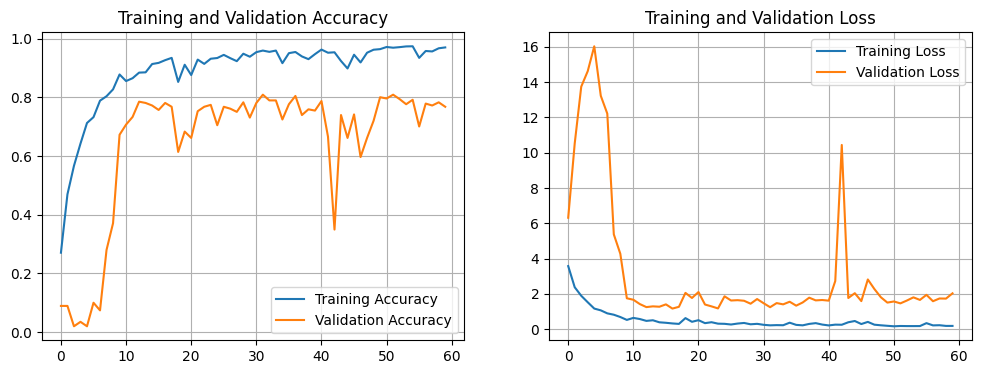

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

figure = plt.gcf()
plt.show()

## Save and load models

#### Save model to disk

In [59]:
model_name = str(input("Enter a title for the saved model..."))
model_path = f"../models/{model_name}/"

if model_name:
    try:
        os.mkdir(model_path)
        model.save(model_path + f"{model_name}.keras")
        print(f"Model successfully saved to {model_path}{model_name}.")

        # Remember to execute plotting cell first
        figure.savefig(model_path + f"{model_name}.png")
    except:
        raise (
            "ERROR: Model name is already in use. Pick another name and try again."
        )

Model successfully saved to ../models/03-cnn_mfcc-argentinian_dataset-60_species/03-cnn_mfcc-argentinian_dataset-60_species.


#### Load previous model

In [3]:
model_name = str(input("Type model name..."))

if model_name:
    model_path = f"../models/{model_name}/"

model = tf.keras.models.load_model(model_path + f"{model_name}.keras")

## Model evaluation and prediction

In [ ]:
eval_loss, eval_acc = model.evaluate(x=x_test, y=y_test)

In [51]:
SAMPLE_RATE = 16000
SAMPLE_LENGTH = 1

MFCC_COUNT = 26
HOP = 512
FFT = 2048


# Load audio file and get preprocessed segments
filename = 'XC673986 - Giant Antshrike - Batara cinerea.mp3'
segments = generate_preprocessed_samples(filename, sr=SAMPLE_RATE, length=SAMPLE_LENGTH)

mfccs = []

for s in segments:
    mfcc = li.feature.mfcc(y=s, sr=SAMPLE_RATE, n_mfcc=MFCC_COUNT, hop_length=HOP, n_fft=FFT)
    mfccs.append(mfcc.transpose())

# Make predictions in batch
predictions = model.predict(np.asarray(mfccs))

# Get predicted label for each segment
predicted_labels = []
for p in predictions:
    label = np.argmax(p)
    label_str = label_map[label]
    probability = round(p[label] * 100, 2)
    predicted_labels.append((label, label_str, probability))

1/1 [==============================] - 0s 15ms/step


In [52]:
predicted_labels

[(5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 99.98),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 99.99),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 99.95),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 98.61),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 82.43),
 (5, 'Batara cinerea', 100.0),
 (5, 'Batara cinerea', 90.5),
 (50, 'Tapera naevia', 84.17)]

### Preprocessing functions

In [10]:
# Generate butterworth highpass coefficients
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


# Apply filter to signal
def apply_butter_highpass(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [11]:
# Remove sections of silence or low intensity signal
def remove_silence(signal, thresh=18, hop=2048, plot=False):
    splits = li.effects.split(y=signal, top_db=thresh, frame_length=(hop * 2), hop_length=hop)
    if plot:
        peak = np.max(signal)
        plt.subplots(figsize=(12, 4))
        plt.plot(signal)
        plt.vlines(splits, ymin=-peak, ymax=peak, color='red')
        plt.show()

    stripped_audio = []

    for s in splits:
        split = signal[s[0] : s[1]]
        stripped_audio.extend(split)

    return np.asarray(stripped_audio)

In [12]:
# Split audio into segments of desired length
def split_audio(signal, target_length, samplerate, plot=False):
    duration = li.get_duration(y=signal, sr=samplerate)
    n_segments = np.ceil(duration / target_length)
    audio_segments = []

    for n in range(int(n_segments)):
        s = signal[samplerate * n * target_length : samplerate * (n + 1) * target_length]

        if len(s) < target_length * samplerate:
            s = np.pad(s, (0, target_length * samplerate - len(s)), 'constant')

        audio_segments.append(s)

        if plot:
            plt.plot(s, alpha=1 / n_segments)

    if plot:
        plt.show()

    return audio_segments

In [13]:
# Apply all signal processing functions to audio and return segments
def generate_preprocessed_samples(path, sr, length, hp=700, rem_noise=False):

    y, sr = li.load(path, sr=sr, mono=True)  # Load audio file

    y = apply_butter_highpass(data=y, cutoff=hp, fs=sr, order=5)  # Apply high-pass filter

    if rem_noise:
        # Delete silent sections
        y = remove_silence(y, thresh=20, hop=2048, plot=False)

    audio_segments = split_audio(
        y, target_length=length, samplerate=sr
    )  # Split into segments of desired length

    return audio_segments